In [1]:
# this notebook is to utilised transfer learning to train a model on a dataset to classify medical image data on breast cancer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import torchvision
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt
import os
import skimage.io as io
import time
import copy

In [2]:
# get root directory
root_dir = '/media/victoru/B612CEC512CE8A37/ai50/pytorch_test/data/breatcancer_data/archive'
id_dir = os.listdir(root_dir)
label_dir = os.listdir(os.path.join(root_dir,id_dir[0]))
sample_dir = os.listdir(os.path.join(root_dir,id_dir[0],label_dir[0]))
num_classes = len(label_dir)

# create transform for data augmentation: normalize, and convert to tensor
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize([50,50]),
        transforms.Normalize(mean, std)
    ])
# define hyperparameters
batch_size = 10
num_epochs = 25
random_seed = 42
shuffle_dataset = True
validation_split = 0.2

#show image
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

In [3]:
#create dataset class for breast cancer data

class breastcancerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # get root directory
        self.root_dir = root_dir
        # get transform
        self.transform = transform
        # get list of label from directory under root_dir
        id_dir = os.listdir(root_dir)
        label_dir = os.listdir(os.path.join(root_dir,id_dir[0]))
        self.data = pd.DataFrame(columns=['id','label','image_name'])
        
        # loop through id in id_dir and label in label_dir to get image name and label
        for id in id_dir:
            for label in label_dir:
                tempdata = pd.DataFrame(columns=['id','label','image_name'])
                tempdata['image_name'] = os.listdir(os.path.join(root_dir, id, label))
                tempdata['id'] = id
                tempdata['label'] = label
                self.data = pd.concat([self.data, tempdata],ignore_index = True, axis = 0)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # get image name and label from dataframe
        img_name = os.path.join(self.root_dir,self.data.iloc[idx, 0],self.data.iloc[idx, 1],self.data.iloc[idx, 2])
        image = io.imread(img_name)
        label = torch.tensor(int(self.data.iloc[idx, 1]))
                
        if self.transform:
            image = self.transform(image)
            
        return image,label

In [4]:
# create dataset object
dataset = breastcancerDataset(root_dir,data_transforms)

# create data indices for training and validation splits
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# create samplers for training and validation splits
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

# create data loaders
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
valid_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

50
<class 'torch.Tensor'>
torch.Size([10, 3, 50, 50])


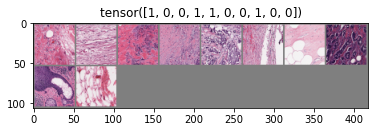

In [5]:
images, classes = next(iter(train_loader))
print(images.shape[2])
print(type(images))
print(images.shape)
imshow(torchvision.utils.make_grid(images), title=classes)

In [6]:
#setting up device to run on cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
for phase in range(2):
    print(phase)

0
1


In [7]:
#create training loop function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in range(2):
            if phase == 0:
                # set model to train mode for training phase
                model.train()
                dataloader = train_loader
            else:
                # set model to evaluate mode for validation phase
                model.eval()
                dataloader = valid_loader
            running_loss = 0.0
            running_corrects = 0

            # Iterate over databatchs for give phase
            n_total_steps = len(dataloader)
            for i, (inputs, labels) in enumerate(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # enable gradient computation when phase is train and forward pass for both phase
                with torch.set_grad_enabled(phase == 0):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward pass only if phase is train
                    if phase == 0:
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_size[phase]
            epoch_acc = running_corrects.double() / dataset_size[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model and update best_acc if phase is validation and epoch_acc is greater than best_acc
            if phase == 1 and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print('Best Acc: {:.4f}'.format(best_acc))
            # adjust learning rate using scheduler if phase is validation
            if phase == 1:
                print('Scheduler step')
                scheduler.step()
        print()

    # record time to train model
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [8]:
# fine tune model
# define fine tuned model as pretrained resnet34
model_ft = models.resnet34(pretrained=True)

# freeze all existing parameters
for param in model_ft.parameters():
    param.requires_grad = False

#get number of input features of last layer
num_features = model_ft.fc.in_features

#replace last layer with new layer with number of classes as output
model_ft.fc = nn.Linear(num_features, num_classes)

# set model to current device
model_ft = model_ft.to(device)

# define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001)

# setup scheduler for learning rate decay
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [9]:
model_ft = train_model(model_ft, criterion, optimizer, step_lr_scheduler, num_epochs=num_epochs)

Epoch 0/24
----------


KeyboardInterrupt: 